In [1]:
# load package# load p 
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import cross_validation


# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/esunfrauddetectiongame1809/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')
#你可以选择修改 ast_note_iteractively kernel 选项来使得 Jupyter 为每一行的变量或语句执行这个操作，以便你可以立即看到多条语句一起输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train=pd.read_csv('train_diss.csv',encoding='big5')
test=pd.read_csv('test_diss.csv',encoding='big5')
data=train.append(test, ignore_index=True)
del(train, test)

In [3]:
data['s_in_a_Day']= data['DATETIME']%(60*60*24)
import math
data['h_in_a_Day']= data['s_in_a_Day'].map(lambda x: math.floor(x/(60*60)))

In [4]:
data= data.astype({'AGNO':'category', 'CATP1':'category', 'CC_CUST_LEVEL':'category', 'CONTP':'category', 'CUORG':'category', 'MCC':'category',
       'MCHNO':'category', 'PAY_TYPE':'category', 'SCITY':'category', 'STOCN':'category', 'TSCFG':'category','h_in_a_Day':'category','ETYMD':'category'})
#,'ACQIC':'category'

In [5]:
temp1 = data.groupby(by='MCHNO', as_index=False).agg({'ECFG': pd.Series.mean})
temp1.rename(columns={'ECFG':'MCHNO_ECFG_MEAN'},inplace=True)
data=pd.merge(data, temp1, how='left', on=['MCHNO'])
#data=temp_m
#data['MCHNO_ECFG_MEAN']=temp1.ECFG
#temp2 = data.groupby(by='ACQIC', as_index=False).agg({'h_in_a_Day': pd.Series.mode})
#data['ACQIC_h_mode']=temp2.h_in_a_Day

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002377 entries, 0 to 1002376
Data columns (total 62 columns):
ACCT_VINTAGE                     909821 non-null float64
ACQIC                            971473 non-null float64
AGE                              1002377 non-null int64
AGNO                             1002377 non-null category
ANDFG                            1002377 non-null int64
APPFG                            1002377 non-null int64
AVAILABLE_LIMIT_AMT              909821 non-null float64
BNSFG                            1002377 non-null int64
BNSPT                            1002377 non-null int64
BONUS_POINTS                     909821 non-null float64
CANO                             1002377 non-null int64
CATP1                            1002377 non-null category
CATP2                            1002377 non-null int64
CC_CUST_LEVEL                    960347 non-null category
CC_PAY_LEVEL_CODE                909658 non-null float64
CC_VINTAGE                       1

In [7]:
dataTrain = data[pd.notnull(data['FRAUD_IND'])]
dataTest = data[~pd.notnull(data['FRAUD_IND'])]
dataTrain.columns
del(data)

Index(['ACCT_VINTAGE', 'ACQIC', 'AGE', 'AGNO', 'ANDFG', 'APPFG',
       'AVAILABLE_LIMIT_AMT', 'BNSFG', 'BNSPT', 'BONUS_POINTS', 'CANO',
       'CATP1', 'CATP2', 'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE', 'CC_VINTAGE',
       'CGDCT', 'CHID', 'CONTP', 'CREDIT_LIMIT_AMT', 'CREDIT_REVOLVING_RATE',
       'CREDIT_USE_RATE', 'CUORG', 'CURRENT_CASH_ADV_AMT', 'CURRENT_FEE',
       'CURRENT_INSTALLMENT_BAL', 'CURRENT_INSTALLMENT_PURCH_AMT',
       'CURRENT_PURCH_AMT', 'CURRENT_VIO_AMT', 'DATETIME', 'ECFG', 'EDU_CODE',
       'ETYMD', 'FALLBACK_IND', 'FEDFG', 'FEEFG', 'FLAM1', 'FRAUD_IND',
       'GENDER_CODE', 'INCOME_RANGE_CODE', 'INSFG', 'ITERM', 'LSCFG',
       'LST_CYCLE_UNPAID_BAL', 'MARITAL_STATUS_CODE', 'MCC', 'MCHNO',
       'NATION_CODE', 'OCUP_CODE', 'OVRLT', 'PAY_TYPE', 'POSITION_CODE',
       'REVOLVING_AMT', 'REVOLVING_INTEREST', 'SAMFG', 'SCITY', 'STOCN',
       'TSCFG', 'TXKEY', 's_in_a_Day', 'h_in_a_Day', 'MCHNO_ECFG_MEAN'],
      dtype='object')

In [8]:
dataTrain = dataTrain[['TXKEY', 'ACQIC', 'AGE', 'ANDFG', 'APPFG','AVAILABLE_LIMIT_AMT',
        'BNSFG', 'BNSPT', # 'CANO',
       'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE',
       'CC_VINTAGE', 'CGDCT', 'CONTP', 'CREDIT_LIMIT_AMT',
        'CREDIT_USE_RATE','CURRENT_PURCH_AMT', 'ECFG', 'EDU_CODE', 'ETYMD',
       'FALLBACK_IND', 'FEEFG','FEDFG', 'FLAM1', 'FRAUD_IND',
       'GENDER_CODE', 'INSFG', 'ITERM',#'LSCFG',
        'MCC', 'MCHNO',
        'OVRLT', 'PAY_TYPE',# 'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST',
        'SAMFG', 'SCITY', 'STOCN','TSCFG', 's_in_a_Day', 'h_in_a_Day', 'MCHNO_ECFG_MEAN']]
#去掉y
dataTest = dataTest[['ACQIC', 'AGE', 'ANDFG', 'APPFG','AVAILABLE_LIMIT_AMT',
        'BNSFG', 'BNSPT', # 'CANO',
       'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE',
       'CC_VINTAGE', 'CGDCT', 'CONTP', 'CREDIT_LIMIT_AMT',
        'CREDIT_USE_RATE','CURRENT_PURCH_AMT', 'ECFG', 'EDU_CODE', 'ETYMD',
       'FALLBACK_IND', 'FEEFG','FEDFG', 'FLAM1',
       'GENDER_CODE',  'INSFG', 'ITERM', #'LSCFG',
        'MCC', 'MCHNO',
       'OVRLT', 'PAY_TYPE', #'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST',
       'SAMFG', 'SCITY', 'STOCN','TSCFG', 's_in_a_Day', 'h_in_a_Day', 'MCHNO_ECFG_MEAN']]
#去掉key
X_feature = dataTrain[['ACQIC', 'AGE', 'ANDFG', 'APPFG','AVAILABLE_LIMIT_AMT',
        'BNSFG', 'BNSPT', # 'CANO',
        'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE',
       'CC_VINTAGE', 'CGDCT', 'CONTP', 'CREDIT_LIMIT_AMT',
        'CREDIT_USE_RATE', 'CURRENT_PURCH_AMT', 'ECFG', 'EDU_CODE', 'ETYMD',
       'FALLBACK_IND', 'FEEFG','FEDFG', 'FLAM1',
       'GENDER_CODE',  'INSFG', 'ITERM',# 'LSCFG',
        'MCC', 'MCHNO',
       'OVRLT', 'PAY_TYPE', #'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST',
       'SAMFG', 'SCITY', 'STOCN','TSCFG', 's_in_a_Day', 'h_in_a_Day', 'MCHNO_ECFG_MEAN']]
y_t =dataTrain['FRAUD_IND']

In [9]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.3, random_state=13)

In [10]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [11]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators = 150, random_state=0) #, objective = 'binary'


param_grid = {
    'objective':['binary'],
    'learning_rate': [0.11], 
    'num_leaves': [64],
    'feature_fraction': [0.8],
    'bagging_fraction': [0.9],
    'max_depth':[9],
    #'max_bin': [6],
    'bagging_freq':[4],
    'lambda_l1': [20] , #[44,133] then 44 [44,88] then 44 np.arange(38,44,1) np.arange(16,20,1)
    'lambda_l2': [7] ,#np.arange(11,15,1) then 13
    #'min_split_gain': [0.04], 
    'min_child_weight': [2] 
}

LGBM_grid = GridSearchCV(estimator, param_grid,scoring='f1')
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators = 150, random_state=0, 
                                     objective = LGBM_grid.best_params_['objective'],
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                             bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              #max_bin = LGBM_grid.best_params_['max_bin'],
                                bagging_freq = LGBM_grid.best_params_['bagging_freq'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                            #min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight']
                                    )
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print("Predicting is over")

Start training...


GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=150,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'objective': ['binary'], 'learning_rate': [0.11], 'num_leaves': [64], 'feature_fraction': [0.8], 'bagging_fraction': [0.9], 'max_depth': [9], 'bagging_freq': [4], 'lambda_l1': [20], 'lambda_l2': [7], 'min_child_weight': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Best parameters found by grid search are: {'bagging_fraction': 0.9, 'bagging_freq': 4, 'feature_fraction': 0.8, 'lambda_l1': 20, 'lambda_l2': 7, 'learning_rate': 0.11, 'max_depth': 9, 'min_child_weight': 2, 'num_leaves': 64, 'objective': 'binary'}
Start predicting...
Predicting is over


Accuracy:0.968
Classification report
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98    137018
        1.0       0.89      0.88      0.89     21995

avg / total       0.97      0.97      0.97    159013

Confusion matrix
[[134622   2396]
 [  2623  19372]]
ROC AUC Score
0.9895697625158081
Feature importances: [197, 680, 30, 99, 423, 0, 0, 141, 110, 802, 121, 6, 387, 341, 490, 8, 179, 93, 9, 15, 7, 427, 50, 20, 7, 908, 986, 17, 2, 33, 732, 221, 46, 190, 647, 23]
Plot feature importances...


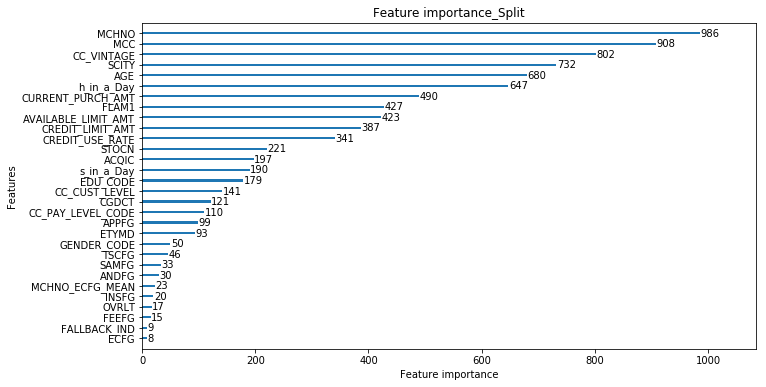

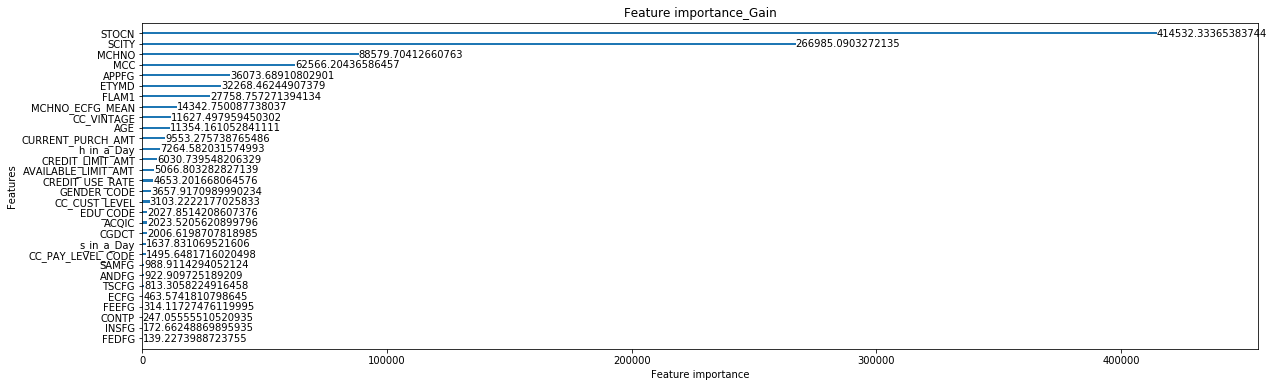

In [12]:
#對test算performance
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
split_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, ignore_zero=False,figsize=(11, 6),grid=False, title='Feature importance_Split')
gain_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, importance_type='gain',figsize=(20, 6),grid=False, title='Feature importance_Gain')


In [13]:
#對test算 f1_score
from sklearn.metrics import f1_score
y_pred_val = LGBM_grid_final_fit.predict(X_test)
f1_score(y_test,y_pred_val,average=None)

array([0.98170005, 0.88531408])

In [14]:
#拿全部的dataTrain來建
LGBM_grid_final_fit_all = LGBM_grid_final.fit(X_feature, y_t)

In [15]:
LGBM_grid_final_fit_res =LGBM_grid_final_fit_all.predict_proba(dataTest)

In [16]:
df_p = pd.DataFrame({'p0':LGBM_grid_final_fit_res[:,0],'p1':LGBM_grid_final_fit_res[:,1]})

In [17]:
submit=pd.read_csv('sampleSubmission.csv',encoding='big5')
out = pd.concat([submit, df_p], axis=1, ignore_index=True)
out.sort_values(by=[3], ascending=False, inplace=True)
out.rename(columns={0:'TXKEY', 1:'FRAUD_IND', 2:'p0', 3:'p1'},inplace=True)
print('偽冒機率門檻：',out.iloc[1438,3])#1634=1438/0.88
out.FRAUD_IND[out.p1>=out.iloc[1438,3]]=1

偽冒機率門檻： 0.9126337445451806


In [18]:
ttl= out['FRAUD_IND'].sum()
ttl

1440

In [19]:
out=out[['TXKEY','FRAUD_IND']]
out.to_csv("submit.csv", index= False)

In [20]:
print('This submission: public score: 0.38777 and private score: 0.35044 ')

This submission: public score: 0.38777 and private score: 0.35044 
